# <font color=blue><div align="center">Seats Allocation within an Aircraft</div></font>

### <font color=blue><div align="center">29-02-2024</div></font>

## Modules

In [1]:
# Basic modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import random

# Gurobi module
from gurobipy import *

## Data Extraction

In [2]:
number_of_seats = 174
weight_f = 70
weight_m = 85
weight_d = 92.5
number_of_rows = 29
number_of_columns = 6

In [3]:
# Load the Excel file into a pandas DataFrame
df = pd.read_excel('./DataSeating 2024.xlsx', sheet_name=2 , skipfooter=2)

In [4]:
# Display the DataFrame
df

,Numéro du groupe,Femmes,Hommes,WCHR,TransitTime
0,1,NaN,1.0,NaN,00:00:00
1,2,1.0,NaN,NaN,02:20:00
2,3,1.0,1.0,NaN,00:55:00
3,4,NaN,1.0,NaN,00:00:00
4,5,1.0,NaN,NaN,00:00:00
...,...,...,...,...,...
116,117,2.0,NaN,NaN,01:05:00
117,118,1.0,NaN,NaN,01:35:00
118,119,NaN,1.0,NaN,01:35:00
119,120,NaN,1.0,NaN,00:00:00


In [5]:

Passagers = dict()
i = 1

number_f = 0
number_m = 0
number_d = 0
transit_times= set()
for group in df.itertuples():
    for j in range(2,5):
        if not pd.isna(group[j]):
            for k in range(int(group[j])):
                Passagers[i] = {'gender': j-2, 'group':group[1], 'transit': float('inf') }
                if group[5].hour*60 + group[5].minute != 0:
                    Passagers[i]['transit'] = group[5].hour*60 + group[5].minute
                    transit_times.add(group[5].hour*60 + group[5].minute)
                if j == 2: number_f+=1
                elif j==3: number_m+=1
                else: number_d+=1

                i+=1    
Passagers

{1: {'gender': 1, 'group': 1, 'transit': inf},
 2: {'gender': 0, 'group': 2, 'transit': 140},
 3: {'gender': 0, 'group': 3, 'transit': 55},
 4: {'gender': 1, 'group': 3, 'transit': 55},
 5: {'gender': 1, 'group': 4, 'transit': inf},
 6: {'gender': 0, 'group': 5, 'transit': inf},
 7: {'gender': 0, 'group': 6, 'transit': 55},
 8: {'gender': 1, 'group': 6, 'transit': 55},
 9: {'gender': 1, 'group': 7, 'transit': inf},
 10: {'gender': 1, 'group': 8, 'transit': 90},
 11: {'gender': 1, 'group': 8, 'transit': 90},
 12: {'gender': 1, 'group': 9, 'transit': inf},
 13: {'gender': 1, 'group': 10, 'transit': inf},
 14: {'gender': 0, 'group': 11, 'transit': 130},
 15: {'gender': 1, 'group': 12, 'transit': 130},
 16: {'gender': 0, 'group': 13, 'transit': 70},
 17: {'gender': 0, 'group': 14, 'transit': 55},
 18: {'gender': 1, 'group': 14, 'transit': 55},
 19: {'gender': 1, 'group': 15, 'transit': inf},
 20: {'gender': 0, 'group': 16, 'transit': 140},
 21: {'gender': 0, 'group': 17, 'transit': inf},
 

In [6]:
Groups = dict()

for i, passager in Passagers.items():

    if passager['group'] in Groups:
        Groups[passager['group']].append(i)
    else :
        Groups[passager['group']] = [i]
for i in df['Numéro du groupe'].values:
    if len(Groups[i]) ==1: del(Groups[i])
Groups

{3: [3, 4],
 6: [7, 8],
 8: [10, 11],
 14: [17, 18],
 26: [30, 31],
 27: [32, 33],
 28: [34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52],
 34: [58, 59],
 36: [61, 62],
 37: [63, 64],
 43: [70, 71],
 44: [72, 73],
 47: [76, 77, 78],
 55: [86, 87],
 62: [94, 95],
 63: [96, 97],
 65: [99, 100],
 66: [101, 102],
 67: [103, 104],
 72: [109, 110],
 76: [114, 115],
 79: [118, 119],
 80: [120, 121],
 85: [126, 127],
 91: [133, 134],
 107: [150, 151],
 109: [153, 154, 155, 156],
 112: [159, 160],
 115: [163, 164, 165],
 117: [167, 168],
 121: [172, 173]}

## Model

Defining the relevant variables of the problem

In [8]:

m = Model("Seats_Allocation")

AssignmenVarDict = {(i, j, k) : m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k}')
                    for i in range(1, number_of_rows + 1)
                    for j in range(1, number_of_columns + 1)
                    for k in range(1, len(Passagers)+1)}

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-04


The constraints

- Every person has a seat

In [49]:
#Redandant 
"""SEATSASSIGNMENTCONST = m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                             for i in range(1, number_of_rows + 1)
                                             for j in range(1, number_of_columns + 1)
                                             for k in range(1,len(Passagers)+1)])
                                             == len(Passagers))"""


'SEATSASSIGNMENTCONST = m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]\n                                             for i in range(1, number_of_rows + 1)\n                                             for j in range(1, number_of_columns + 1)\n                                             for k in range(1,len(Passagers)+1)])\n                                             == len(Passagers))'

- Every person has one seat

In [9]:
PERSONSEATCONSTDIC = { k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)]
                                                for i in range(1, number_of_rows + 1)
                                                for j in range(1, number_of_columns + 1) ])
                                                == 1)
                                                for k in range(1,len(Passagers)+1) }

- Every seat is allocated to a single person

In [10]:
ALLOCATIONCONSTDIC = { (i,j) : m.addConstr(quicksum([AssignmenVarDict[(i,j,k)]
                                                     for k in range(1, len(Passagers)+1)])
                                                     <=1)
                                                     for i in range(1, number_of_rows + 1)
                                                     for j in range(1, number_of_columns+1) }

- Barycenter constraint

In [11]:

i_m = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])

i_f = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])

i_d = quicksum([weight_m * i* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

i_bary = (i_m + i_f +i_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

j_m = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==1])

j_f = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==0])

j_d = quicksum([weight_m * j* AssignmenVarDict[(i,j,k)]
                for i in range(1, number_of_rows+1)
                for j in range(1, number_of_columns+1 )
                for k in range(1, len(Passagers)+1)
                if Passagers[k]['gender']==2])

j_bary = (j_m + j_f + j_d)/( weight_d* number_d + weight_f * number_f + weight_m * number_m)

In [12]:
IMAXBARYCONST = m.addConstr(i_bary <= 17)
IMINBARYCONST = m.addConstr(13 <= i_bary)
JMAXBARYCONST = m.addConstr(j_bary <= 4)
JMINBARYCONST = m.addConstr(3 <= j_bary )

- A disabeled person has 4 seats on the aisle side

In [13]:

SeatPer_WCHR_CONST = {k: m.addConstr(quicksum([AssignmenVarDict[(i, j, k)] 
                                               for i in range(1, number_of_rows ) 
                                               for j in [3, 5] 
                                               ]) == 1, name=f"SeatPerWCHR{k}")
                                               for k in range(1, len(Passagers) + 1)
                                               if Passagers[k]['gender'] == 2}

for k in range(1, len(Passagers) + 1):
    if Passagers[k]['gender'] == 2:
        for i in range(1, number_of_rows):
            for j in [3, 5]:
                m.addConstr(AssignmenVarDict[(i, j, k)] + quicksum(
                      [AssignmenVarDict[(i, j - 1, p)] for p in range(1, len(Passagers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i}_{j-1}')
                
                m.addConstr(AssignmenVarDict[(i, j, k)] +quicksum(
                      [AssignmenVarDict[(i+1, j, p)] for p in range(1, len(Passagers)+1)]
                      ) <= 1, 
                            name=f'Neighbor_WCHR{k}_{i+1}_{j}')
                m.addConstr(AssignmenVarDict[(i, j, k)]+ quicksum(
                      [AssignmenVarDict[(i+1, j - 1, p)] for p in range(1, len(Passagers)+1)]
                      ) <= 1,  
                            name=f'Neighbor_WCHR{k}_{i+1}_{j-1}')

## Objectif Time

- Transit time

In [14]:
transit_obj = quicksum( [ AssignmenVarDict[(i,j,k)]* i*(1/Passagers[k]['transit'])
                      for i in range(1, number_of_rows+1)
                      for j in range(1, number_of_columns+1 )
                      for k in range(1, len(Passagers)+1)
                      if Passagers[k]['transit'] != float('inf') ])

m.setObjective(transit_obj, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

## Optimisation

In [15]:

m.optimize()


if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()

                                                   z* = 14.56                                                   



- Transit time visualization

In [16]:
def generate_blue_gradations(num_gradations):
    gradations = []
    for i in range(num_gradations):
         # Linearly decrease the green component from full (255) to 0
        green_intensity = int(255 * (1 - i / (num_gradations - 1)))
        # Keep the red component at full intensity
        red_intensity = 255
        # Combine the components into a color value
        color_value = f"#{red_intensity:02X}{green_intensity:02X}00"
        gradations.append(color_value)
    return gradations
graduation = generate_blue_gradations(len(transit_times))
transit_times = list(transit_times)
transit_times.sort()
color_transit = dict()
for i in range(len(transit_times)):
    color_transit[transit_times[i]] = graduation[-i-1]

In [17]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['transit']!=float('inf'): colors1[i-1][j-1] = color_transit[Passagers[k]['transit']]
                else:
                    data2[i-1][j-4] = k
                    if Passagers[k]['transit']!=float('inf'): colors2[i-1][j-4] = color_transit[Passagers[k]['transit']]

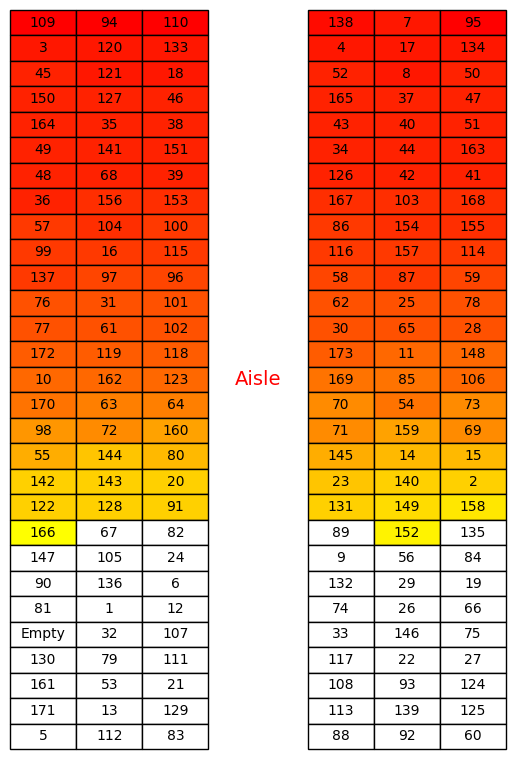

In [18]:

def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

- Disabled visualization

In [19]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['gender']==2 :
                        colors1[i-1][j-1] = '#800080'
                        colors1[i-1][j-2] = '#800080'
                        colors1[i][j-1] = '#800080'
                        colors1[i][j-2] = '#800080'
                else:
                    data2[i-1][j-4] = k
                    if Passagers[k]['gender']==2:
                        colors2[i-1][j-4] = '#800080'
                        colors2[i-1][j-5] = '#800080'
                        colors2[i][j-4] = '#800080'
                        colors2[i][j-5] = '#800080'




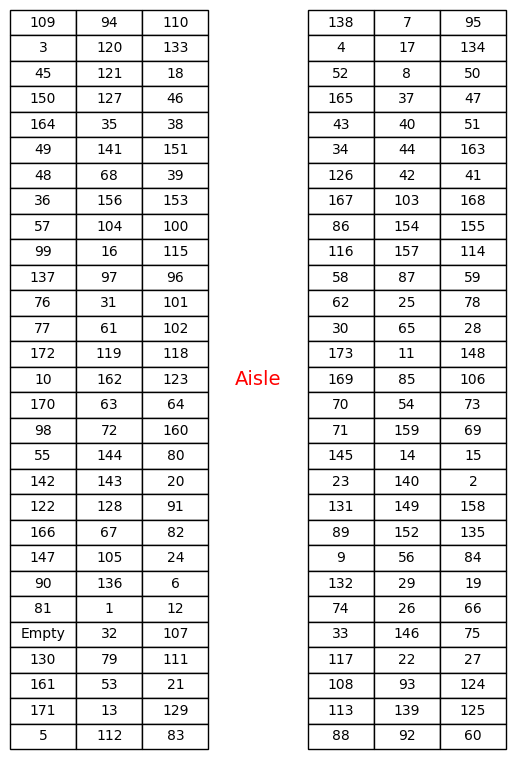

In [20]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()

## Objectif Grouping

- 1st formulation

In [21]:
grouping = quicksum([AssignmenVarDict[(i_1, j_1, group[k_1])] * AssignmenVarDict[(i_2, j_2, group[k_2])] * (0.8 * abs(i_1 - i_2) + 0.2 * abs(j_1 - j_2)) \
                     for group in Groups.values() \
                     for k_1 in range(len(group)) \
                     for k_2 in range(k_1 + 1, len(group)) \
                     for i_1 in range(1, number_of_rows + 1) \
                     for j_1 in range(1, number_of_columns + 1) \
                     for i_2 in range(1, number_of_rows + 1) \
                     for j_2 in range(1, number_of_columns + 1)])

m.setObjective(grouping, GRB.MINIMIZE)

m.params.outputflag = 0 

m.update()

- 2nd Formulation

In [63]:
DECOUPLINGVAR = {(i,j,k_1, k_2): m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k_1}_{k_2}')
                 for i in range(1, number_of_rows+1)
                 for j in range(1, number_of_columns)
                 for k_1 in Passager_Group
                 for k_2 in Passager_Group[k_1]}

In [64]:
DECOUPLINGVAR_Extended = {(i,j,k_1, k_2): m.addVar(vtype = GRB.BINARY, name=f'passager_{i}_{j}_{k_1}_{k_2}')
                 for i in range(1, number_of_rows)
                 for j in range(1, number_of_columns+1)
                 for k_1 in Passager_Group
                 for k_2 in Passager_Group[k_1]}

In [65]:
DECOUPLINGCONST1 = {(i,j,k_1,k_2): m.addConstr(DECOUPLINGVAR[(i,j,k_1,k_2)]<= AssignmenVarDict[(i,j,k_1)])
                                     for i in range(1, number_of_rows+1)
                 for j in range(1, number_of_columns)
                 for k_1 in Passager_Group
                 for k_2 in Passager_Group[k_1]}

In [66]:
DECOUPLINGCONST1_Extended = {(i,j,k_1,k_2): m.addConstr(DECOUPLINGVAR_Extended[(i,j,k_1,k_2)]<= AssignmenVarDict[(i,j,k_1)])
                                     for i in range(1, number_of_rows)
                 for j in range(1, number_of_columns+1)
                 for k_1 in Passager_Group
                 for k_2 in Passager_Group[k_1]}

In [67]:
DECOUPLINGCONST2 = {(i,j,k_1,k_2): m.addConstr(DECOUPLINGVAR[(i,j,k_1,k_2)]<= AssignmenVarDict[(i,j+1,k_2)])
                                     for i in range(1, number_of_rows+1)
                 for j in range(1, number_of_columns)
                 for k_1 in Passager_Group
                 for k_2 in Passager_Group[k_1]}

In [68]:
DECOUPLINGCONST2_Extended = {(i,j,k_1,k_2): m.addConstr(DECOUPLINGVAR_Extended[(i,j,k_1,k_2)]<= AssignmenVarDict[(i+1,j,k_2)])
                                     for i in range(1, number_of_rows)
                 for j in range(1, number_of_columns+1)
                 for k_1 in Passager_Group
                 for k_2 in Passager_Group[k_1]}

In [69]:
DECOUPLINGCONST3 = {(i,j,k_1,k_2): m.addConstr(DECOUPLINGVAR[(i,j,k_1,k_2)]>= AssignmenVarDict[(i,j,k_1)]- (1- AssignmenVarDict[(i,j+1,k_2)]))
                                     for i in range(1, number_of_rows+1)
                 for j in range(1, number_of_columns)
                 for k_1 in Passager_Group
                 for k_2 in Passager_Group[k_1]}

In [70]:
DECOUPLINGCONST3_Extended = {(i,j,k_1,k_2): m.addConstr(DECOUPLINGVAR_Extended[(i,j,k_1,k_2)]>= AssignmenVarDict[(i,j,k_1)]- (1- AssignmenVarDict[(i+1,j,k_2)]))
                                     for i in range(1, number_of_rows)
                 for j in range(1, number_of_columns+1)
                 for k_1 in Passager_Group
                 for k_2 in Passager_Group[k_1]}

In [71]:
grouping = quicksum([10*DECOUPLINGVAR[(i,j,k_1,k_2)] \
                        for i in range(1, number_of_rows + 1) \
                        for j in [1,2,4,5] \
                      for k_1 in Passager_Group
                      for k_2 in Passager_Group[k_1] ])    

grouping_aisle = quicksum([5*DECOUPLINGVAR[(i,3,k_1,k_2)] \
                        for i in range(1, number_of_rows + 1) \
                      for k_1 in Passager_Group
                      for k_2 in Passager_Group[k_1] ])

grouping_extended = quicksum([2*DECOUPLINGVAR_Extended[(i,j,k_1,k_2)] \
                        for i in range(1, number_of_rows ) \
                        for j in range(1, number_of_columns+1) \
                      for k_1 in Passager_Group
                      for k_2 in Passager_Group[k_1] ])         

m.setObjective(grouping + grouping_aisle + grouping_extended , GRB.MAXIMIZE)

m.params.outputflag = 1

m.update()

Set parameter OutputFlag to value 1


- 3rd formulation

In [72]:
"""grouping = quicksum([AssignmenVarDict[(i, j, k_1)] + AssignmenVarDict[(i, j+1, k_2)] \
                        for i in range(1, number_of_rows + 1) \
                        for j in range(1, number_of_columns) \
                      for k_1 in Passager_Group
                      for k_2 in Passager_Group[k_1] ])                     

m.setObjective(grouping, GRB.MAXIMIZE)

m.params.outputflag = 0 

m.update()"""

'grouping = quicksum([AssignmenVarDict[(i, j, k_1)] + AssignmenVarDict[(i, j+1, k_2)]                         for i in range(1, number_of_rows + 1)                         for j in range(1, number_of_columns)                       for k_1 in Passager_Group\n                      for k_2 in Passager_Group[k_1] ])                     \n\nm.setObjective(grouping, GRB.MAXIMIZE)\n\nm.params.outputflag = 0 \n\nm.update()'

## Optimisation


In [22]:
# Set iteration limit
m.setParam('TimeLimit', 600)
m.optimize()


if m.status == GRB.INF_OR_UNBD:
    m.setParam(GRB.Param.Presolve, 0)
    m.optimize()

if m.status == GRB.INFEASIBLE:
    print(m.display(), "\n\tTHERE IS NO SOLUTION!!!")
elif m.status == GRB.UNBOUNDED:
    print(m.display(), "\n\tNOT BOUNDED!!!")
else:
    print(f'z* = {round(m.objVal, 2)}'.center(8*14))

print()

                                                   z* = 315.8                                                   



- Grouping Visualization

In [23]:

def generate_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):

        red = random.randint(0, 255)
        green = random.randint(0, 255)
        blue = random.randint(0, 255)

        color_value = "#{:02X}{:02X}{:02X}".format(red, green, blue)
        colors.append(color_value)
    return colors

graduation = generate_random_colors(len(Groups))
indices_groups = list(Groups.keys())
color_group = {indices_groups[i-1] : graduation[i-1] for i in range(1, len(Groups)+1)}


In [24]:
data1 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
data2 = [['Empty' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

colors1 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]
colors2 = [[ '#FFFFFF' for _ in range(number_of_columns//2)] for _ in range(number_of_rows)]

for i in range(1, number_of_rows + 1):
    for j in range(1, number_of_columns + 1):
        for k in range(1, len(Passagers) + 1):
            if AssignmenVarDict[(i,j,k)].x == 1:
                if j<4:
                    data1[i-1][j-1] = k
                    if Passagers[k]['group']in color_group: colors1[i-1][j-1] = color_group[Passagers[k]['group']]
                else:
                    data2[i-1][j-4] = k
                    if Passagers[k]['group'] in color_group: colors2[i-1][j-4] = color_group[Passagers[k]['group']]

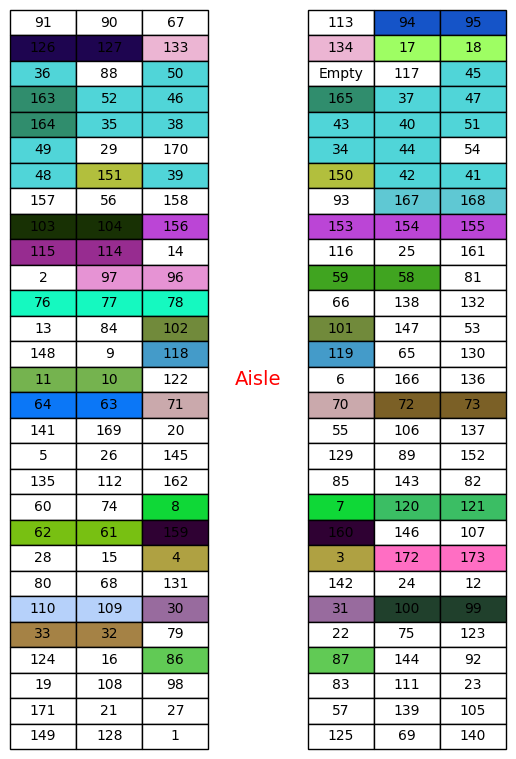

In [25]:
def create_table(ax, data, colors):
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 2])
    rows, cols = len(data), len(data[0])
    width, height = 100 , 100 


    for i in range(rows):
        for j in range(cols):
            table.add_cell(i, j, width, height, text=data[i][j], loc='center', facecolor=colors[i][j])

    ax.add_table(table)


fig, (ax1, ax2) = plt.subplots(1, 2)

create_table(ax1, data1, colors1)
create_table(ax2, data2, colors2)


ax1.annotate('Aisle', xy=(1, 1), xytext=(1.25, 1),
             textcoords='axes fraction', ha='center', va='center', color='red', fontsize=14)



plt.subplots_adjust(wspace=0.5)

plt.show()